In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import pathlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = "datasets/wv_3d_linear0"

In [3]:
train_features = pickle.load(open(f"{data_dir}/train_features.pkl","rb"))
valid_features = pickle.load(open(f"{data_dir}/valid_features.pkl","rb"))
test_features = pickle.load(open(f"{data_dir}/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/train")])
y_valid = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/valid")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/test")])

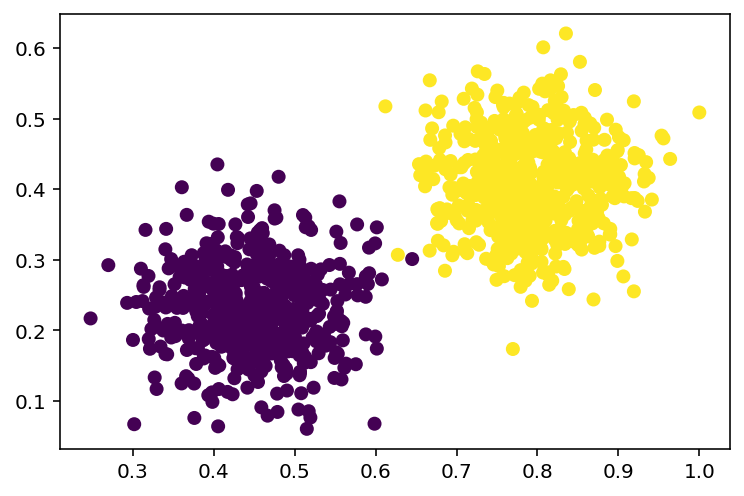

In [5]:
plt.scatter(train_features[:,0],train_features[:,1],c=y_train)

## search alignment

In [46]:
total_weights = np.array(list(itertools.product([0]+[10**i for i in range(10)],repeat=2)))
total_weights = np.hstack([total_weights,np.ones_like(total_weights)])

In [67]:
aligns = np.array([evals.distorted_1nn(train_features, y_train, test_features, y_test, weights) for weights in total_weights])

(array([ 1.,  0.,  0.,  0.,  0.,  0., 11.,  6.,  4., 99.]),
 array([0.495 , 0.5455, 0.596 , 0.6465, 0.697 , 0.7475, 0.798 , 0.8485,
        0.899 , 0.9495, 1.    ]),
 <BarContainer object of 10 artists>)

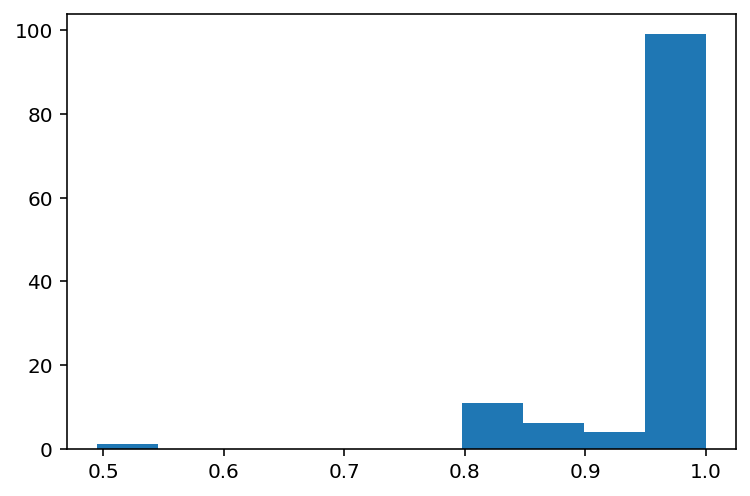

In [68]:
plt.hist(aligns)

In [72]:
align = 0.9775
total_weights[np.where(aligns==align)[0]]

array([[    10, 100000,      1,      1]])

In [65]:
np.where(aligns==align)

(array([], dtype=int64),)

In [71]:
np.unique(aligns)

array([0.495 , 0.8175, 0.82  , 0.835 , 0.84  , 0.8425, 0.8475, 0.85  ,
       0.8525, 0.8575, 0.86  , 0.8675, 0.89  , 0.9025, 0.9075, 0.9175,
       0.95  , 0.9575, 0.96  , 0.9675, 0.9775, 0.985 , 0.9875, 0.99  ,
       0.9925, 0.995 , 0.9975, 1.    ])

In [73]:
evals.distorted_1nn(train_features, y_train, test_features, y_test, [1,  0,1,1])

0.99

## testing

In [74]:
weights = [
    [0,1000,1,1],
    [0,1,1,1],
    [1,1000000,1,1],
    [1,10000,1,1],
    [1,1,1,1]
]
# aligns = [0.82,0.87,0.90,0.95,1]
for weight in weights:
    print(evals.distorted_1nn(train_features, y_train, test_features, y_test, weight))

0.82
0.8675
0.89
0.95
0.95
1.0


#### aligns & filtered

In [3]:
weights = [
    [0,1000,1,1],
    [0,1,1,1],
    [1,1000000,1,1],
    [1,10000,1,1],
    [1,1,1,1]
]
aligns = [0.82,0.87,0.90,0.95,1]
assert(len(weights)==len(aligns))
total = 30000
triplet_dir = "datasets/wv_3d_linear0_triplets"

In [77]:
for weight,align in zip(weights, aligns):
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weight, total)
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    pathlib.Path(align_dir).mkdir(parents=True, exist_ok=True)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

### noisy

In [10]:
aligns = ["0.82","0.9"]
triplet_dir = "datasets/wv_3d_linear0_triplets"

In [11]:
for align in aligns:
    train_triplets = pickle.load(open(f"{triplet_dir}/align={align}/train_triplets.pkl","rb"))
    valid_triplets = pickle.load(open(f"{triplet_dir}/align={align}/valid_triplets.pkl","rb"))
    test_triplets = pickle.load(open(f"{triplet_dir}/align={align}/test_triplets.pkl","rb"))
    for p in np.arange(1,9,1)/10:
        dir = os.path.join(f"{triplet_dir}/align={align}_noisy",str(p))
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

        train_noisy = gen.get_noisy_triplets(train_triplets, p)
        valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
        test_noisy = gen.get_noisy_triplets(test_triplets, p)
        pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
        pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
        pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [12]:
for align in aligns:    
    for p in np.arange(1,9,1)/10:
        dir = os.path.join(f"{triplet_dir}/align={align}_noisy",str(p))
        train_triplets = pickle.load(open(f"{dir}/train_triplets.pkl","rb"))
        valid_triplets = pickle.load(open(f"{dir}/valid_triplets.pkl","rb"))
        test_triplets = pickle.load(open(f"{dir}/test_triplets.pkl","rb"))
        train_triplets_filtered = gen.filter_train_triplets(train_triplets, y_train)
        valid_triplets_filtered = gen.filter_mixed_triplets(valid_triplets, y_train, y_valid)
        test_triplets_filtered = gen.filter_mixed_triplets(test_triplets, y_train, y_test)
        pickle.dump(train_triplets_filtered, open(f"{dir}/train_triplets_filtered.pkl","wb"))
        pickle.dump(valid_triplets_filtered, open(f"{dir}/valid_triplets_filtered.pkl","wb"))
        pickle.dump(test_triplets_filtered, open(f"{dir}/test_triplets_filtered.pkl","wb"))

### nums

In [13]:
aligns = ["0.82","0.9"]
triplet_dir = "datasets/wv_3d_linear0_triplets"
def dropout(triplets,p):
    keepers = np.random.choice(np.arange(len(triplets)),int(len(triplets)*p),replace=False)
    return np.array(triplets)[keepers]

In [14]:
for align in aligns:
    train_triplets = pickle.load(open(f"{triplet_dir}/align={align}/train_triplets.pkl","rb"))
    valid_triplets = pickle.load(open(f"{triplet_dir}/align={align}/valid_triplets.pkl","rb"))
    test_triplets = pickle.load(open(f"{triplet_dir}/align={align}/test_triplets.pkl","rb"))
    for p in [1/128,1/64,1/32,1/16,1/8,1/4,1/2]:
        dir = os.path.join(f"{triplet_dir}/align={align}_num",str(p))
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

        train_noisy = dropout(train_triplets, p)
        valid_noisy = dropout(valid_triplets, p)
        test_noisy = dropout(test_triplets, p)
        pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
        pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
        pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [15]:
for align in aligns:
    for p in [1/128,1/64,1/32,1/16,1/8,1/4,1/2]:
        dir = os.path.join(f"{triplet_dir}/align={align}_num",str(p))
        train_triplets = pickle.load(open(f"{dir}/train_triplets.pkl","rb"))
        valid_triplets = pickle.load(open(f"{dir}/valid_triplets.pkl","rb"))
        test_triplets = pickle.load(open(f"{dir}/test_triplets.pkl","rb"))
        train_triplets_filtered = gen.filter_train_triplets(train_triplets, y_train)
        valid_triplets_filtered = gen.filter_mixed_triplets(valid_triplets, y_train, y_valid)
        test_triplets_filtered = gen.filter_mixed_triplets(test_triplets, y_train, y_test)
        pickle.dump(train_triplets_filtered, open(f"{dir}/train_triplets_filtered.pkl","wb"))
        pickle.dump(valid_triplets_filtered, open(f"{dir}/valid_triplets_filtered.pkl","wb"))
        pickle.dump(test_triplets_filtered, open(f"{dir}/test_triplets_filtered.pkl","wb"))

## yaml generation

In [6]:
data = "wv_3d_linear0"
triplet_dir = data + "_triplets"
weights = [
    [0,1000,1,1],
    [0,1,1,1],
    [1,1000000,1,1],
    [1,10000,1,1],
    [1,1,1,1]
]
aligns = [0.82,0.87,0.90,0.95,1]
yaml_dir = "models/configs/wv_3d_linear0/triplets"

In [94]:
dir = f"{yaml_dir}/unfiltered/aligns"
for weight,align in zip(weights, aligns):
    unfiltered_configs =  {"wandb_project": data + "_aligns",
                                "wandb_group": f"align={align}",
                                "train_triplets": f"../datasets/{triplet_dir}/align={align}/train_triplets.pkl",
                                "valid_triplets": f"../datasets/{triplet_dir}/align={align}/valid_triplets.pkl",
                                "test_triplets": f"../datasets/{triplet_dir}/align={align}/test_triplets.pkl",
                                "weights": weight,
                                "powers": [2,2],
                                "filtered": False}
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    oc.save(unfiltered_configs, f"{dir}/align={align}.yaml")

In [96]:
dir = f"{yaml_dir}/filtered/aligns"
for weight,align in zip(weights, aligns):
    filtered_configs =  {"wandb_project": data + "_aligns",
                                "wandb_group": f"align={align}_filtered",
                                "train_triplets": f"../datasets/{triplet_dir}/align={align}/train_triplets_filtered.pkl",
                                "valid_triplets": f"../datasets/{triplet_dir}/align={align}/valid_triplets_filtered.pkl",
                                "test_triplets": f"../datasets/{triplet_dir}/align={align}/test_triplets_filtered.pkl",
                                "weights": weight,
                                "powers": [2,2],
                                "filtered": True}
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    oc.save(filtered_configs, f"{dir}/align={align}.yaml")

### noise

In [9]:
weights = [
    [0,1000,1,1],
    [1,1000000,1,1],
]
data = "wv_3d_linear0"
triplet_dir = data + "_triplets"
aligns = ["0.82","0.9"]
yaml_dir = "models/configs/wv_3d_linear0/triplets"

In [19]:
for weight, align in zip(weights, aligns):
    dir = f"{yaml_dir}/unfiltered/noisy_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    for p in np.arange(1,9,1)/10:
        unfiltered_configs =  {"wandb_project": data + "_noisy",
                                    "wandb_group": f"align={align}_p={p}",
                                    "train_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/train_triplets.pkl",
                                    "valid_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/valid_triplets.pkl",
                                    "test_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/test_triplets.pkl",
                                    "weights": weight,
                                    "powers": [2,2],
                                    "filtered": False}
        oc.save(unfiltered_configs, f"{dir}/p={p}.yaml")

In [20]:
for weight, align in zip(weights, aligns):
    dir = f"{yaml_dir}/filtered/noisy_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    for p in np.arange(1,9,1)/10:
        filtered_configs =  {"wandb_project": data + "_noisy",
                                    "wandb_group": f"align={align}_p={p}_filtered",
                                    "train_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/train_triplets_filtered.pkl",
                                    "valid_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/valid_triplets_filtered.pkl",
                                    "test_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/test_triplets_filtered.pkl",
                                    "weights": weight,
                                    "powers": [2,2],
                                    "filtered": True}
        oc.save(filtered_configs, f"{dir}/p={p}.yaml")

### num

In [6]:
weights = [
    [0,1000,1,1],
    [1,1000000,1,1],
]
data = "wv_3d_linear0"
triplet_dir = data + "_triplets"
aligns = ["0.82","0.9"]
yaml_dir = "models/configs/wv_3d_linear0/triplets"

In [7]:
for weight, align in zip(weights, aligns):
    dir = f"{yaml_dir}/unfiltered/num_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    for p in [1/2, 1/128, 1/64, 1/32,1/16,1/8,1/4]:
        unfiltered_configs =  {"wandb_project": data + "_num",
                                    "wandb_group": f"align={align}_p={p}",
                                    "train_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/train_triplets.pkl",
                                    "valid_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/valid_triplets.pkl",
                                    "test_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/test_triplets.pkl",
                                    "weights": weight,
                                    "powers": [2,2],
                                    "filtered": False,
                                    "model": "MTL_slow"}
        oc.save(unfiltered_configs, f"{dir}/p={p}.yaml")


In [10]:
for weight, align in zip(weights, aligns):
    dir = f"{yaml_dir}/filtered/num_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    for p in [1/2, 1/128, 1/64, 1/32,1/16,1/8,1/4]:
        filtered_configs =  {"wandb_project": data + "_num",
                                    "wandb_group": f"align={align}_p={p}_filtered",
                                    "train_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/train_triplets_filtered.pkl",
                                    "valid_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/valid_triplets_filtered.pkl",
                                    "test_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/test_triplets_filtered.pkl",
                                    "weights": weight,
                                    "powers": [2,2],
                                    "filtered": True,
                                    "model": "MTL_slow"}
        oc.save(filtered_configs, f"{dir}/p={p}.yaml")